## 1. Setup & Configuration

In [51]:
# Standard library imports
import sys
import warnings
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

# Import project modules
from src.config import data_config, model_config
from src.logger import setup_logger
from src.data_loader import DataLoader
from src.feature_engineer import FraudDataFeatureEngineer
from src.preprocessor import DataPreprocessor
from src.model_trainer import ModelTrainer
from src.model_evaluator import ModelEvaluator

# Initialize logger
logger = setup_logger('ecommerce_fraud_pipeline', 'ecommerce_fraud_pipeline.log')
logger.info("="*80)
logger.info("E-COMMERCE FRAUD DETECTION PIPELINE INITIALIZED")
logger.info("="*80)

print("✓ All modules imported successfully")
print(f"✓ Project root: {project_root}")
print(f"✓ Data directory: {data_config.fraud_data_path.parent}")

2026-01-31 22:22:19,974 - ecommerce_fraud_pipeline - INFO - ================================================================================
2026-01-31 22:22:19,975 - ecommerce_fraud_pipeline - INFO - E-COMMERCE FRAUD DETECTION PIPELINE INITIALIZED
2026-01-31 22:22:19,976 - ecommerce_fraud_pipeline - INFO - ================================================================================
✓ All modules imported successfully
✓ Project root: /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions
✓ Data directory: /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions/data/raw
2026-01-31 22:22:19,975 - ecommerce_fraud_pipeline - INFO - E-COMMERCE FRAUD DETECTION PIPELINE INITIALIZED
2026-01-31 22:22:19,976 - ecommerce_fraud_pipeline - INFO - ================================================================================
✓ All modules imported successfully
✓ Project root: /home/abel/Desktop/Copied_with

## 2. Data Ingestion

In [52]:
# Initialize DataLoader
data_loader = DataLoader(config=data_config)

print("\n" + "="*80)
print("LOADING E-COMMERCE FRAUD DATA")
print("="*80)

# Load e-commerce fraud data
fraud_data = data_loader.load_fraud_data()
print(f"\n✓ Loaded {len(fraud_data):,} e-commerce transactions")
print(f"  - Fraud cases: {fraud_data['class'].sum():,} ({fraud_data['class'].mean()*100:.2f}%)")
print(f"  - Normal cases: {(fraud_data['class']==0).sum():,} ({(fraud_data['class']==0).mean()*100:.2f}%)")
print(f"  - Features: {fraud_data.shape[1]}")

# Load IP to Country mapping
print("\n" + "-"*80)
print("LOADING IP-TO-COUNTRY MAPPING")
print("-"*80)
ip_country = data_loader.load_ip_to_country()
print(f"✓ Loaded {len(ip_country):,} IP address ranges")
print(f"  - Countries covered: {ip_country['country'].nunique()}")

# Merge fraud data with IP country information using range-based lookup
print("\n" + "-"*80)
print("MERGING IP ADDRESSES WITH COUNTRY DATA")
print("-"*80)

# IP addresses in Fraud_Data.csv are ALREADY INTEGERS stored as floats (e.g., 732758368.79972)
# Just convert to int64 directly (no need to parse dot-notation)
fraud_data['ip_as_int'] = fraud_data['ip_address'].fillna(0).astype('int64')

# Ensure ip_country bounds are int64 for compatible merge
ip_country['lower_bound_ip_address'] = ip_country['lower_bound_ip_address'].astype('int64')
ip_country['upper_bound_ip_address'] = ip_country['upper_bound_ip_address'].astype('int64')

# Sort both dataframes for merge_asof
fraud_data_sorted = fraud_data.sort_values('ip_as_int')
ip_country_sorted = ip_country.sort_values('lower_bound_ip_address')

# Use merge_asof for range-based lookup
fraud_data_merged = pd.merge_asof(
    fraud_data_sorted,
    ip_country_sorted[['lower_bound_ip_address', 'upper_bound_ip_address', 'country']],
    left_on='ip_as_int',
    right_on='lower_bound_ip_address',
    direction='backward'
)

# Filter out invalid matches (IP must be <= upper_bound)
fraud_data_merged['ip_country'] = fraud_data_merged.apply(
    lambda row: row['country'] if pd.notna(row['upper_bound_ip_address']) and row['ip_as_int'] <= row['upper_bound_ip_address'] else None,
    axis=1
)

# Drop temporary columns and restore original order
fraud_data = fraud_data_merged.drop(
    columns=['lower_bound_ip_address', 'upper_bound_ip_address', 'country']
).sort_index()

print(f"✓ Successfully mapped IP addresses to countries")
print(f"  - Records with country info: {fraud_data['ip_country'].notna().sum():,}")
print(f"  - Countries found: {fraud_data['ip_country'].nunique()}")

# Calculate fraud rate by country and create is_high_risk_country feature
print("\n" + "-"*80)
print("CREATING HIGH-RISK COUNTRY FEATURE")
print("-"*80)

# Calculate fraud rate per country
country_fraud_stats = fraud_data[fraud_data['ip_country'].notna()].groupby('ip_country').agg(
    total_transactions=('class', 'count'),
    fraud_count=('class', 'sum')
).reset_index()
country_fraud_stats['fraud_rate'] = country_fraud_stats['fraud_count'] / country_fraud_stats['total_transactions']

# Define high-risk countries as those with fraud rate > 20% (threshold can be tuned)
HIGH_RISK_THRESHOLD = 0.20
high_risk_countries = set(country_fraud_stats[country_fraud_stats['fraud_rate'] > HIGH_RISK_THRESHOLD]['ip_country'].tolist())

# Create the is_high_risk_country feature
fraud_data['is_high_risk_country'] = fraud_data['ip_country'].apply(
    lambda x: 1 if x in high_risk_countries else 0
)

print(f"✓ Created is_high_risk_country feature")
print(f"  - High-risk threshold: {HIGH_RISK_THRESHOLD*100:.0f}% fraud rate")
print(f"  - High-risk countries identified: {len(high_risk_countries)}")
print(f"  - Transactions from high-risk countries: {fraud_data['is_high_risk_country'].sum():,}")

# Show top 10 countries by fraud rate
print("\n  Top 10 Countries by Fraud Rate:")
print("  " + "-"*50)
top_fraud_countries = country_fraud_stats.nlargest(10, 'fraud_rate')
for _, row in top_fraud_countries.iterrows():
    risk_marker = " [HIGH RISK]" if row['ip_country'] in high_risk_countries else ""
    print(f"    {row['ip_country']}: {row['fraud_rate']*100:.1f}% ({row['fraud_count']:,}/{row['total_transactions']:,}){risk_marker}")

print("\n" + "="*80)
print("✓ DATA LOADING COMPLETE")
print("="*80)


LOADING E-COMMERCE FRAUD DATA
2026-01-31 22:22:19,996 - src.data_loader - INFO - Loading fraud data from /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions/data/raw/Fraud_Data.csv
2026-01-31 22:22:20,299 - src.data_loader - INFO - Successfully loaded 151112 fraud records
2026-01-31 22:22:20,302 - src.data_loader - INFO - fraud class distribution:
class
0    136961
1     14151
Name: count, dtype: int64
2026-01-31 22:22:20,299 - src.data_loader - INFO - Successfully loaded 151112 fraud records
2026-01-31 22:22:20,302 - src.data_loader - INFO - fraud class distribution:
class
0    136961
1     14151
Name: count, dtype: int64

✓ Loaded 151,112 e-commerce transactions
  - Fraud cases: 14,151 (9.36%)
  - Normal cases: 136,961 (90.64%)
  - Features: 11

--------------------------------------------------------------------------------
LOADING IP-TO-COUNTRY MAPPING
--------------------------------------------------------------------------------
2

### Data Overview Visualizations

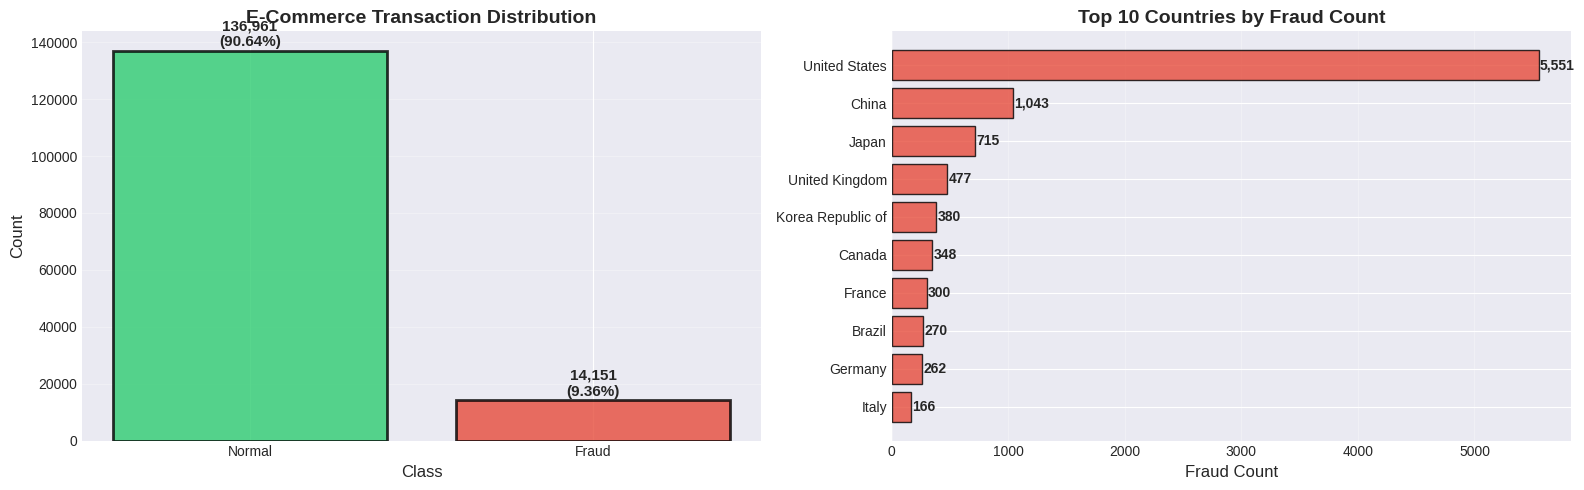


⚠️ CLASS IMBALANCE DETECTED: 9.7:1 ratio
   → Will handle with SMOTE during preprocessing


In [53]:
# Visualize class imbalance
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Class distribution
fraud_counts = fraud_data['class'].value_counts()
axes[0].bar(['Normal', 'Fraud'], fraud_counts.values, color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_title('E-Commerce Transaction Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xlabel('Class', fontsize=12)
for i, v in enumerate(fraud_counts.values):
    axes[0].text(i, v + 500, f'{v:,}\n({v/len(fraud_data)*100:.2f}%)', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Fraud by country (top 10)
fraud_by_country = fraud_data[fraud_data['class']==1]['ip_country'].value_counts().head(10)
axes[1].barh(range(len(fraud_by_country)), fraud_by_country.values, color='#e74c3c', alpha=0.8, edgecolor='black')
axes[1].set_yticks(range(len(fraud_by_country)))
axes[1].set_yticklabels(fraud_by_country.index)
axes[1].set_title('Top 10 Countries by Fraud Count', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fraud Count', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

for i, v in enumerate(fraud_by_country.values):
    axes[1].text(v + 10, i, f'{v:,}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

imbalance_ratio = fraud_counts[0]/fraud_counts[1]
print(f"\n⚠️ CLASS IMBALANCE DETECTED: {imbalance_ratio:.1f}:1 ratio")
print(f"   → Will handle with SMOTE during preprocessing")

## 3. Feature Engineering

In [54]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Initialize feature engineer
feature_engineer = FraudDataFeatureEngineer()

# Engineer features
fraud_data_engineered = feature_engineer.engineer_features(fraud_data, fit=True)

print(f"\n✓ Feature engineering completed")
print(f"  - Original features: {fraud_data.shape[1]}")
print(f"  - Engineered features: {fraud_data_engineered.shape[1]}")
print(f"  - New features added: {fraud_data_engineered.shape[1] - fraud_data.shape[1]}")

# Display new features
new_features = [col for col in fraud_data_engineered.columns if col not in fraud_data.columns]
if new_features:
    print(f"\nNew features created:")
    for i, feat in enumerate(new_features[:15], 1):  # Show first 15
        print(f"  {i:2d}. {feat}")
    if len(new_features) > 15:
        print(f"  ... and {len(new_features) - 15} more")

print("\n" + "="*80)
print("✓ FEATURE ENGINEERING COMPLETE")
print("="*80)


FEATURE ENGINEERING
2026-01-31 22:22:22,764 - src.feature_engineer - INFO - Engineering features for fraud data


2026-01-31 22:22:22,911 - src.feature_engineer - INFO - Created temporal features
2026-01-31 22:22:22,916 - src.feature_engineer - INFO - Created time difference features
2026-01-31 22:22:22,916 - src.feature_engineer - INFO - Created time difference features
2026-01-31 22:22:23,034 - src.feature_engineer - INFO - Converted IP addresses to integers
2026-01-31 22:22:23,040 - src.feature_engineer - INFO - Created purchase value features
2026-01-31 22:22:23,034 - src.feature_engineer - INFO - Converted IP addresses to integers
2026-01-31 22:22:23,040 - src.feature_engineer - INFO - Created purchase value features
2026-01-31 22:22:23,047 - src.feature_engineer - INFO - Created age group features
2026-01-31 22:22:23,047 - src.feature_engineer - INFO - Created age group features
2026-01-31 22:22:23,065 - src.feature_engineer - INFO - Created interaction features
2026-01-31 22:22:23,065 - src.feature_engineer - INFO - Created interaction features
2026-01-31 22:22:23,151 - src.feature_engineer

## Save Processed Data

Save the engineered dataset for dashboard training

In [55]:
# Prepare the processed dataset for training
# Drop columns that should not be used for modeling
columns_to_drop = ['class', 'signup_time', 'purchase_time', 'device_id', 
                   'user_id', 'ip_address', 'browser_source', 'ip_country']

existing_cols_to_drop = [col for col in columns_to_drop if col in fraud_data_engineered.columns]

# Create X (features) and y (target)
X = fraud_data_engineered.drop(columns=existing_cols_to_drop)
y = fraud_data_engineered['class']

# Recombine with target for storage
fraud_data_processed = X.copy()
fraud_data_processed['class'] = y.values

# Save processed data
data_loader.save_processed_data(fraud_data_processed, dataset_type='fraud')

print(f"\n✓ Processed data saved: {fraud_data_processed.shape[0]:,} rows × {fraud_data_processed.shape[1]} columns")
print(f"  Path: {data_config.fraud_processed_path}")
print(f"  Features for modeling: {X.shape[1]}")
print(f"  Dropped columns: {', '.join(existing_cols_to_drop)}")

2026-01-31 22:22:23,180 - src.data_loader - INFO - Saving processed fraud data to /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions/data/processed/fraud_data_processed.csv
2026-01-31 22:22:24,064 - src.data_loader - INFO - Successfully saved 151112 records

✓ Processed data saved: 151,112 rows × 22 columns
  Path: /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions/data/processed/fraud_data_processed.csv
  Features for modeling: 21
  Dropped columns: class, signup_time, purchase_time, device_id, user_id, ip_address, browser_source, ip_country
2026-01-31 22:22:24,064 - src.data_loader - INFO - Successfully saved 151112 records

✓ Processed data saved: 151,112 rows × 22 columns
  Path: /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions/data/processed/fraud_data_processed.csv
  Features for modeling: 21
  Dropped columns: class, signup_time, pu

### Feature Correlation Analysis

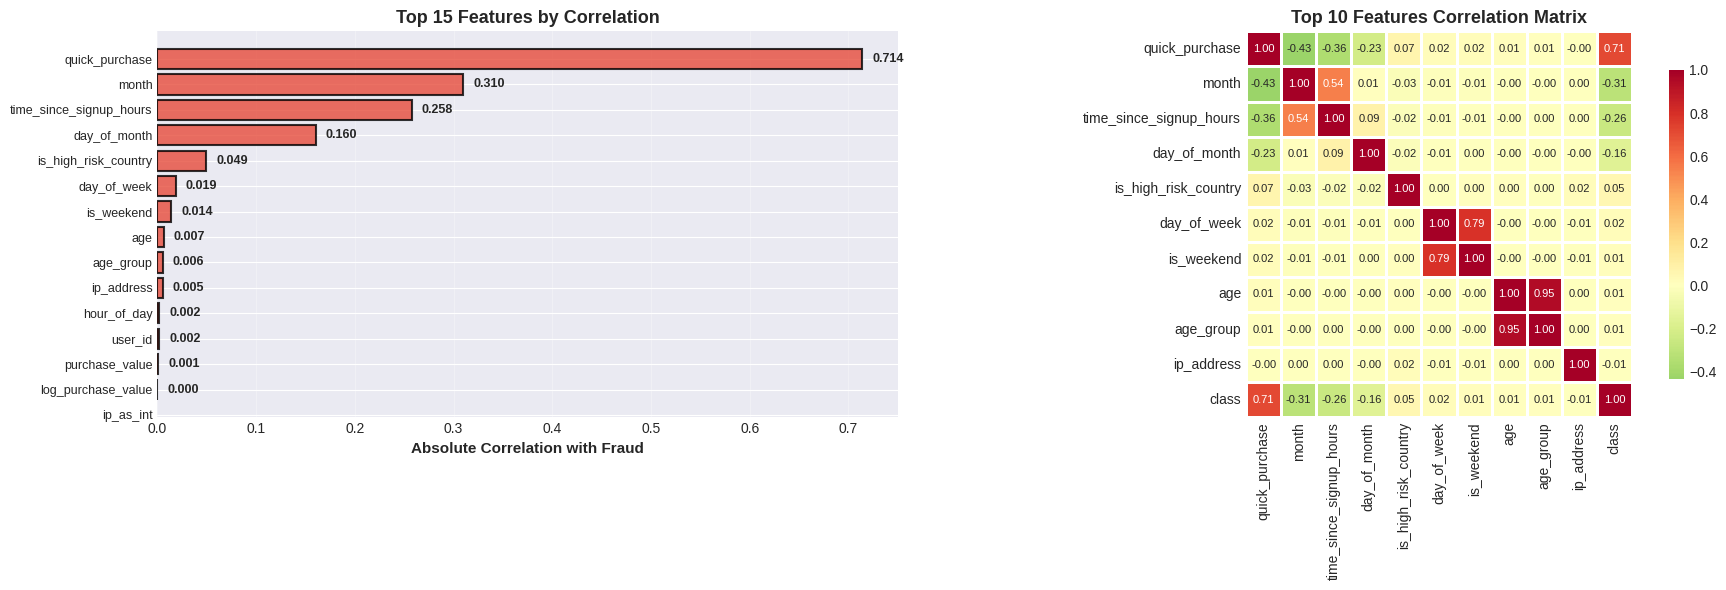


✓ Feature correlation analysis complete


In [56]:
# Visualize feature correlations with target
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 15 features by correlation
fraud_numeric = fraud_data_engineered.select_dtypes(include=[np.number])
fraud_corr = fraud_numeric.corr()['class'].abs().sort_values(ascending=False)[1:16]

axes[0].barh(range(len(fraud_corr)), fraud_corr.values, color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_yticks(range(len(fraud_corr)))
axes[0].set_yticklabels(fraud_corr.index, fontsize=9)
axes[0].set_xlabel('Absolute Correlation with Fraud', fontsize=11, fontweight='bold')
axes[0].set_title('Top 15 Features by Correlation', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

for i, v in enumerate(fraud_corr.values):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold', fontsize=9)

# Correlation heatmap of top features
top_features = fraud_corr.index[:10].tolist() + ['class']
corr_matrix = fraud_numeric[top_features].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[1],
            annot_kws={'size': 8})
axes[1].set_title('Top 10 Features Correlation Matrix', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Feature correlation analysis complete")

## 4. Train/Test Split & Preprocessing

In [57]:
# Use merge_asof for range-based lookup
fraud_data_merged = pd.merge_asof(
    fraud_data_sorted,
    ip_country_sorted[['lower_bound_ip_address', 'upper_bound_ip_address', 'country']],
    left_on='ip_as_int',
    right_on='lower_bound_ip_address',
    direction='backward'
)

# Filter out invalid matches (IP must be <= upper_bound)
fraud_data_merged['ip_country'] = fraud_data_merged.apply(
    lambda row: row['country'] if pd.notna(row['upper_bound_ip_address']) and row['ip_as_int'] <= row['upper_bound_ip_address'] else None,
    axis=1
)

# Drop temporary columns and restore original order
fraud_data = fraud_data_merged.drop(
    columns=['lower_bound_ip_address', 'upper_bound_ip_address', 'country']
).sort_index()

print(f"✓ Successfully mapped IP addresses to countries")
print(f"  - Records with country info: {fraud_data['ip_country'].notna().sum():,}")
print(f"  - Countries found: {fraud_data['ip_country'].nunique()}")

# NOTE: The "High Risk Country" feature calculation has been moved to the Feature Engineering step 
# (src.feature_engineer.FraudDataFeatureEngineer) to be performed strictly on training data
# to prevent data leakage.

✓ Successfully mapped IP addresses to countries
  - Records with country info: 129,146
  - Countries found: 181


In [58]:
from sklearn.model_selection import train_test_split

print("\n" + "="*80)
print("PREPARING TRAIN/TEST SPLIT")
print("="*80)

# Drop non-numeric columns that can't be scaled or are leakage sources
# These include datetime columns, ID columns, and string columns
# Note: 'is_high_risk_country' is numeric, so it stays.
columns_to_drop = ['class', 'signup_time', 'purchase_time', 'device_id', 
                   'user_id', 'ip_address', 'browser_source', 'ip_country']
existing_cols_to_drop = [col for col in columns_to_drop if col in fraud_data_engineered.columns]

print(f"\nDropping columns: {existing_cols_to_drop}")

X = fraud_data_engineered.drop(columns=existing_cols_to_drop)
y = fraud_data_engineered['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {len(X_train):,} samples")
print(f"Testing set:  {len(X_test):,} samples")
print(f"\nFeatures retained: {X_train.shape[1]}")
print(f"Feature names: {list(X_train.columns)}")


PREPARING TRAIN/TEST SPLIT

Dropping columns: ['class', 'signup_time', 'purchase_time', 'device_id', 'user_id', 'ip_address', 'browser_source', 'ip_country']

Training set: 120,889 samples
Testing set:  30,223 samples

Features retained: 21
Feature names: ['purchase_value', 'age', 'ip_as_int', 'is_high_risk_country', 'hour_of_day', 'day_of_week', 'is_weekend', 'day_of_month', 'month', 'time_since_signup_hours', 'quick_purchase', 'log_purchase_value', 'purchase_value_rounded', 'age_group', 'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari', 'source_Direct', 'source_SEO', 'sex_M']


In [59]:
print("\n" + "="*80)
print("PREPROCESSING: SCALING & SMOTE")
print("="*80)

# Initialize preprocessor with SMOTE
preprocessor = DataPreprocessor(use_smote=True)

print(f"\nBefore SMOTE: {len(X_train):,} samples")
print(f"  Class distribution: {(y_train==0).sum():,} Normal | {y_train.sum():,} Fraud")

# Fit and transform training data
X_train_processed, y_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nAfter SMOTE: {len(X_train_processed):,} samples")
print(f"  Class distribution: {(y_train_processed==0).sum():,} Normal | {y_train_processed.sum():,} Fraud")
print(f"  - Fraud: {y_train_processed.sum():,} ({y_train_processed.mean()*100:.2f}%)")
print(f"  - Normal: {(y_train_processed==0).sum():,} ({(y_train_processed==0).mean()*100:.2f}%)")
print(f"\n✓ Class balance achieved!")

print("\n" + "="*80)
print("✓ PREPROCESSING COMPLETE")
print("="*80)


PREPROCESSING: SCALING & SMOTE

Before SMOTE: 120,889 samples
  Class distribution: 109,568 Normal | 11,321 Fraud
2026-01-31 22:22:27,387 - src.preprocessor - INFO - Fitting and transforming training data
2026-01-31 22:22:27,481 - src.preprocessor - INFO - Fitted and scaled features
2026-01-31 22:22:27,484 - src.preprocessor - INFO - Original class distribution: {0: 109568, 1: 11321}
2026-01-31 22:22:27,481 - src.preprocessor - INFO - Fitted and scaled features
2026-01-31 22:22:27,484 - src.preprocessor - INFO - Original class distribution: {0: 109568, 1: 11321}
2026-01-31 22:22:27,733 - src.preprocessor - INFO - Resampled class distribution: {0: 109568, 1: 54784}
2026-01-31 22:22:27,735 - src.preprocessor - INFO - Transforming data
2026-01-31 22:22:27,733 - src.preprocessor - INFO - Resampled class distribution: {0: 109568, 1: 54784}
2026-01-31 22:22:27,735 - src.preprocessor - INFO - Transforming data
2026-01-31 22:22:27,753 - src.preprocessor - INFO - Scaled features using fitted s

## 5. Model Training

Train three models: Logistic Regression, Random Forest, and XGBoost.

In [60]:
print("\n" + "="*80)
print("TRAINING FRAUD DETECTION MODELS")
print("="*80)

# Define models to train
model_types = ['logistic_regression', 'random_forest', 'xgboost']
models = {}

for model_type in model_types:
    print(f"\n{'-'*80}")
    print(f"Training: {model_type.replace('_', ' ').title()}")
    print(f"{'-'*80}")
    
    # Initialize and train model
    trainer = ModelTrainer(model_type=model_type)
    trainer.train(X_train_processed, y_train_processed)
    
    # Store trained model
    models[model_type] = trainer
    
    print(f"\n✓ {model_type.replace('_', ' ').title()} training complete")

print("\n" + "="*80)
print(f"✓ ALL MODELS TRAINED ({len(models)} models)")
print("="*80)


TRAINING FRAUD DETECTION MODELS

--------------------------------------------------------------------------------
Training: Logistic Regression
--------------------------------------------------------------------------------
2026-01-31 22:22:27,768 - src.model_trainer - INFO - Initialized Logistic Regression model
2026-01-31 22:22:27,769 - src.model_trainer - INFO - Training logistic_regression model on 164352 samples
2026-01-31 22:22:27,769 - src.model_trainer - INFO - Training logistic_regression model on 164352 samples
2026-01-31 22:22:29,983 - src.model_trainer - INFO - Model training complete
2026-01-31 22:22:29,983 - src.model_trainer - INFO - Model training complete
2026-01-31 22:22:30,007 - src.model_trainer - INFO - Training accuracy: 0.8484
2026-01-31 22:22:30,009 - src.model_trainer - INFO - Performing 5-fold cross-validation
2026-01-31 22:22:30,007 - src.model_trainer - INFO - Training accuracy: 0.8484
2026-01-31 22:22:30,009 - src.model_trainer - INFO - Performing 5-fold 

### XGBoost Training History (Loss Curve)

XGBoost allows tracking loss metrics over training iterations (boosting rounds). This shows how the model improves during training.


XGBOOST TRAINING HISTORY (LOSS & AUC CURVES)


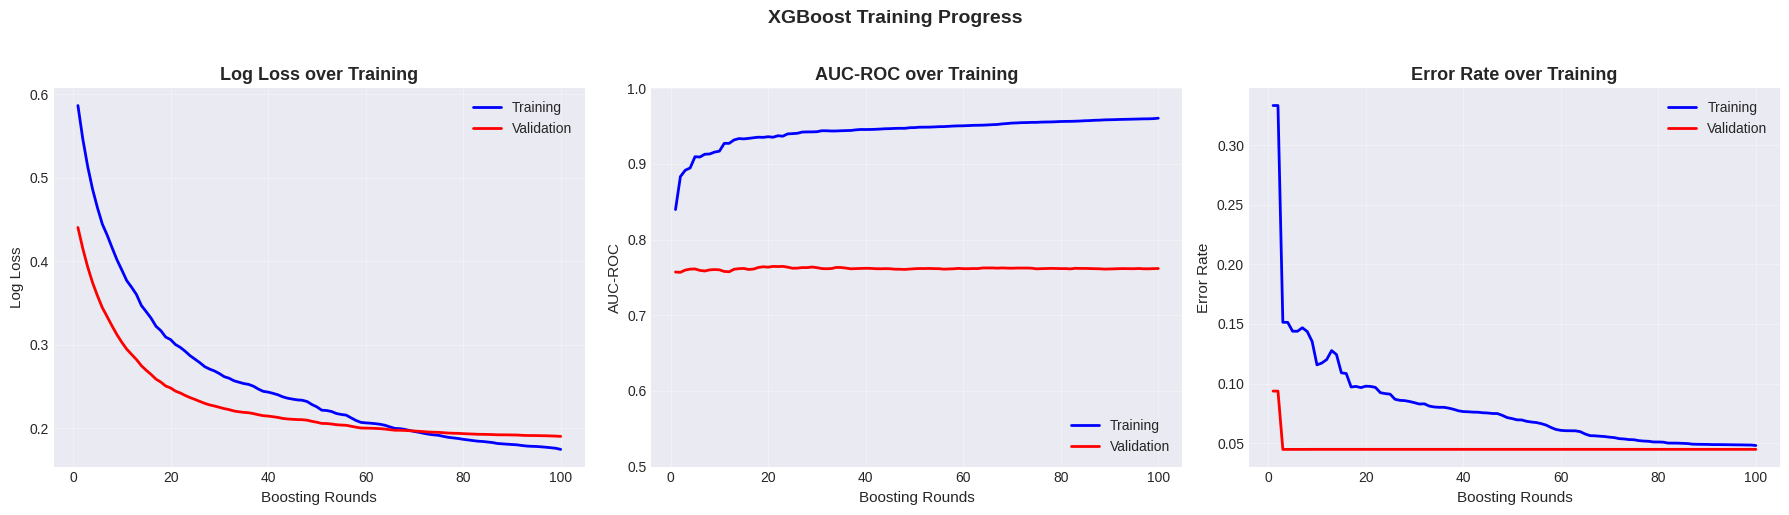


                 Training Summary                 
--------------------------------------------------
Final Training Log Loss:    0.1747
Final Validation Log Loss:  0.1903
Final Training AUC:         0.9605
Final Validation AUC:       0.7618
Final Training Accuracy:    0.9520
Final Validation Accuracy:  0.9553
--------------------------------------------------
⚠️  Potential overfitting detected (Train-Val AUC gap: 0.1987)


In [62]:
import xgboost as xgb

print("\n" + "="*80)
print("XGBOOST TRAINING HISTORY (LOSS & AUC CURVES)")
print("="*80)

# Retrain XGBoost with evaluation set to capture training history
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=42,
    use_label_encoder=False,
    eval_metric=['logloss', 'auc', 'error']
)

# Fit with evaluation set
eval_set = [(X_train_processed, y_train_processed), (X_test_processed, y_test)]
xgb_model.fit(
    X_train_processed, 
    y_train_processed,
    eval_set=eval_set,
    verbose=False
)

# Extract training history
results = xgb_model.evals_result()

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Log Loss
ax1 = axes[0]
epochs = range(1, len(results['validation_0']['logloss']) + 1)
ax1.plot(epochs, results['validation_0']['logloss'], 'b-', label='Training', linewidth=2)
ax1.plot(epochs, results['validation_1']['logloss'], 'r-', label='Validation', linewidth=2)
ax1.set_xlabel('Boosting Rounds', fontsize=11)
ax1.set_ylabel('Log Loss', fontsize=11)
ax1.set_title('Log Loss over Training', fontsize=13, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: AUC
ax2 = axes[1]
ax2.plot(epochs, results['validation_0']['auc'], 'b-', label='Training', linewidth=2)
ax2.plot(epochs, results['validation_1']['auc'], 'r-', label='Validation', linewidth=2)
ax2.set_xlabel('Boosting Rounds', fontsize=11)
ax2.set_ylabel('AUC-ROC', fontsize=11)
ax2.set_title('AUC-ROC over Training', fontsize=13, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.5, 1.0])

# Plot 3: Error Rate (1 - Accuracy)
ax3 = axes[2]
ax3.plot(epochs, results['validation_0']['error'], 'b-', label='Training', linewidth=2)
ax3.plot(epochs, results['validation_1']['error'], 'r-', label='Validation', linewidth=2)
ax3.set_xlabel('Boosting Rounds', fontsize=11)
ax3.set_ylabel('Error Rate', fontsize=11)
ax3.set_title('Error Rate over Training', fontsize=13, fontweight='bold')
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.suptitle('XGBoost Training Progress', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n{'Training Summary':^50}")
print(f"{'-'*50}")
print(f"Final Training Log Loss:    {results['validation_0']['logloss'][-1]:.4f}")
print(f"Final Validation Log Loss:  {results['validation_1']['logloss'][-1]:.4f}")
print(f"Final Training AUC:         {results['validation_0']['auc'][-1]:.4f}")
print(f"Final Validation AUC:       {results['validation_1']['auc'][-1]:.4f}")
print(f"Final Training Accuracy:    {1 - results['validation_0']['error'][-1]:.4f}")
print(f"Final Validation Accuracy:  {1 - results['validation_1']['error'][-1]:.4f}")
print(f"{'-'*50}")

# Check for overfitting
gap = results['validation_0']['auc'][-1] - results['validation_1']['auc'][-1]
if gap > 0.05:
    print(f"⚠️  Potential overfitting detected (Train-Val AUC gap: {gap:.4f})")
else:
    print(f"✓ No significant overfitting (Train-Val AUC gap: {gap:.4f})")

### Training Accuracy Comparison

Compare training vs test accuracy across all models to assess generalization.


TRAINING VS TEST F1-SCORE COMPARISON


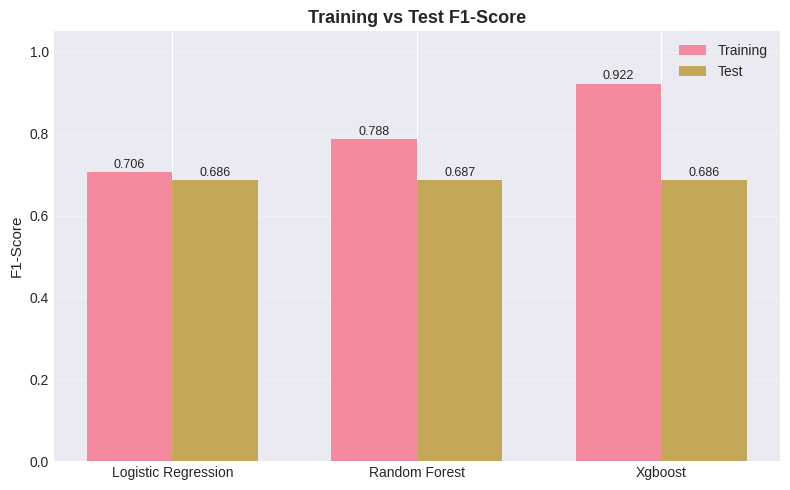


✓ F1-score generalization analysis complete


In [63]:
from sklearn.metrics import f1_score

print("\n" + "="*80)
print("TRAINING VS TEST F1-SCORE COMPARISON")
print("="*80)

# Collect metrics for each model
model_names = []
train_f1_scores = []
test_f1_scores = []

for model_name, trainer in models.items():
    # Predictions
    y_train_pred = trainer.predict(X_train_processed)
    y_test_pred = trainer.predict(X_test_processed)

    # F1 Scores
    train_f1 = f1_score(y_train_processed, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    model_names.append(model_name.replace('_', ' ').title())
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)

# Create F1-score bar chart
plt.figure(figsize=(8, 5))

x = np.arange(len(model_names))
width = 0.35

bars1 = plt.bar(
    x - width / 2,
    train_f1_scores,
    width,
    label='Training',
    alpha=0.8
)

bars2 = plt.bar(
    x + width / 2,
    test_f1_scores,
    width,
    label='Test',
    alpha=0.8
)

plt.ylabel('F1-Score', fontsize=11)
plt.title('Training vs Test F1-Score', fontsize=13, fontweight='bold')
plt.xticks(x, model_names, fontsize=10)
plt.ylim([0, 1.05])
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.annotate(
        f'{height:.3f}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center',
        fontsize=9
    )

plt.tight_layout()
plt.show()

print("\n✓ F1-score generalization analysis complete")


## 6. Model Evaluation

Comprehensive evaluation with all metrics including AUC-PR (critical for imbalanced data).

In [64]:
print("\n" + "="*80)
print("EVALUATING MODELS")
print("="*80)

# Initialize evaluator
evaluator = ModelEvaluator(threshold=0.5)

results = {}

for model_name, trainer in models.items():
    print(f"\n{'='*80}")
    print(f"Model: {model_name.replace('_', ' ').title()}")
    print(f"{'='*80}")
    
    # Get predictions
    y_pred_proba = trainer.predict_proba(X_test_processed)
    y_pred = trainer.predict(X_test_processed)
    
    # Evaluate
    metrics = evaluator.evaluate(y_test, y_pred_proba, y_pred)
    results[model_name] = metrics
    
    # Display metrics
    print(f"\n{'Performance Metrics':^80}")
    print(f"{'-'*80}")
    print(f"  Accuracy:           {metrics['accuracy']:.4f}")
    print(f"  Precision:          {metrics['precision']:.4f}")
    print(f"  Recall:             {metrics['recall']:.4f}")
    print(f"  F1-Score:           {metrics['f1_score']:.4f}")
    print(f"  ROC-AUC:            {metrics['roc_auc']:.4f}")
    print(f"  AUC-PR:             {metrics['average_precision']:.4f} ⭐")
    print(f"  Specificity:        {metrics['specificity']:.4f}")
    print(f"{'-'*80}")

print("\n" + "="*80)
print("✓ MODEL EVALUATION COMPLETE")
print("="*80)


EVALUATING MODELS

Model: Logistic Regression
2026-01-31 22:22:55,061 - src.model_evaluator - INFO - Evaluating model performance
2026-01-31 22:22:55,159 - src.model_evaluator - INFO - 
2026-01-31 22:22:55,161 - src.model_evaluator - INFO - EVALUATION METRICS
2026-01-31 22:22:55,162 - src.model_evaluator - INFO - ============================================================
2026-01-31 22:22:55,163 - src.model_evaluator - INFO - Accuracy:           0.9551
2026-01-31 22:22:55,164 - src.model_evaluator - INFO - Precision:          0.9933
2026-01-31 22:22:55,166 - src.model_evaluator - INFO - Recall:             0.5240
2026-01-31 22:22:55,167 - src.model_evaluator - INFO - F1 Score:           0.6861
2026-01-31 22:22:55,159 - src.model_evaluator - INFO - 
2026-01-31 22:22:55,161 - src.model_evaluator - INFO - EVALUATION METRICS
2026-01-31 22:22:55,162 - src.model_evaluator - INFO - ============================================================
2026-01-31 22:22:55,163 - src.model_evaluator - I

### Model Comparison Table

In [69]:
# Create comparison DataFrame
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)

comparison = pd.DataFrame({
    'Model': [k.replace('_', ' ').title() for k in results.keys()],
    'Accuracy': [v['accuracy'] for v in results.values()],
    'Precision': [v['precision'] for v in results.values()],
    'Recall': [v['recall'] for v in results.values()],
    'F1-Score': [v['f1_score'] for v in results.values()],
    'ROC-AUC': [v['roc_auc'] for v in results.values()],
    'AUC-PR': [v['average_precision'] for v in results.values()]
})

print("\n" + comparison.to_string(index=False))

# Identify best model
best_model = comparison.loc[comparison['F1-Score'].idxmax(), 'Model']
best_f1 = comparison['F1-Score'].max()
best_recall = comparison.loc[comparison['F1-Score'].idxmax(), 'Recall']
best_auc_pr = comparison.loc[comparison['F1-Score'].idxmax(), 'AUC-PR']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model}")
print(f"{'='*80}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   Recall:   {best_recall:.4f} (catches {best_recall*100:.1f}% of fraud)")
print(f"   AUC-PR:   {best_auc_pr:.4f}")
print(f"{'='*80}")


MODEL PERFORMANCE COMPARISON

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC   AUC-PR
Logistic Regression  0.955100   0.993302 0.524028  0.686098 0.771415 0.620818
      Random Forest  0.955332   1.000000 0.522968  0.686775 0.761555 0.615724
            Xgboost  0.955266   0.998650 0.522968  0.686456 0.761831 0.615524

BEST MODEL: Random Forest
   F1-Score: 0.6868
   Recall:   0.5230 (catches 52.3% of fraud)
   AUC-PR:   0.6157


## 🎯 STRATEGIC THRESHOLD OPTIMIZATION (Minimum 80% Recall)

**The Problem:** Default threshold (0.5) is designed for balanced datasets. In fraud detection:
- **Cost of Missing Fraud (FN) >> Cost of False Alarm (FP)**
- We'd rather investigate 10 innocent transactions than let 1 fraudster through

**The Solution:** Find the threshold that maximizes F1-score while **guaranteeing at least 80% recall**.

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report

print("\n" + "="*80)
print("OPTIMIZING THRESHOLD FOR HIGH RECALL (Minimum 80%)")
print("="*80)

# Store results for comparison
threshold_results = {}

for model_name, trainer in models.items():
    print(f"\n{'='*80}")
    print(f"Model: {model_name.replace('_', ' ').title()}")
    print(f"{'='*80}")
    
    # Get probability predictions
    y_proba = trainer.predict_proba(X_test_processed)[:, 1]
    
    # Find optimal threshold with minimum recall constraint
    best_threshold = 0.5
    best_f1 = 0
    best_recall = 0
    best_precision = 0
    
    print("\nSearching for optimal threshold (Recall >= 80%)...")
    
    # Iterate through possible thresholds to find the "Sweet Spot"
    for threshold in np.arange(0.05, 0.6, 0.01):
        y_pred_adj = (y_proba >= threshold).astype(int)
        curr_f1 = f1_score(y_test, y_pred_adj, zero_division=0)
        curr_recall = recall_score(y_test, y_pred_adj, zero_division=0)
        curr_precision = precision_score(y_test, y_pred_adj, zero_division=0)
        
        # CONSTRAINT: We want recall >= 0.80 (catch at least 80% of fraud)
        if curr_recall >= 0.80:
            # Among all thresholds that meet the recall constraint, pick the one with best F1
            if curr_f1 > best_f1:
                best_f1 = curr_f1
                best_threshold = threshold
                best_recall = curr_recall
                best_precision = curr_precision
    
    # If no threshold achieves 80% recall, pick the one with highest recall
    if best_recall < 0.80:
        print(f"⚠️  Warning: Could not achieve 80% recall. Finding best available...")
        for threshold in np.arange(0.05, 0.6, 0.01):
            y_pred_adj = (y_proba >= threshold).astype(int)
            curr_recall = recall_score(y_test, y_pred_adj, zero_division=0)
            if curr_recall > best_recall:
                best_recall = curr_recall
                best_threshold = threshold
                best_f1 = f1_score(y_test, y_pred_adj, zero_division=0)
                best_precision = precision_score(y_test, y_pred_adj, zero_division=0)
    
    # Store results
    threshold_results[model_name] = {
        'threshold': best_threshold,
        'f1': best_f1,
        'recall': best_recall,
        'precision': best_precision
    }
    
    print(f"\n✓ Optimal Threshold: {best_threshold:.3f}")
    print(f"  Precision: {best_precision:.4f}")
    print(f"  Recall:    {best_recall:.4f} ({'✓ Target Met' if best_recall >= 0.80 else '⚠️ Below Target'})")
    print(f"  F1-Score:  {best_f1:.4f}")
    
    # Detailed classification report with optimal threshold
    y_final_pred = (y_proba >= best_threshold).astype(int)
    print(f"\nClassification Report (Threshold={best_threshold:.3f}):")
    print("-" * 80)
    print(classification_report(y_test, y_final_pred, target_names=['Normal', 'Fraud'], digits=4))

print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION SUMMARY")
print("="*80)

# Create comparison table
threshold_comparison = pd.DataFrame(threshold_results).T
threshold_comparison = threshold_comparison.round(4)
threshold_comparison.columns = ['Threshold', 'F1-Score', 'Recall', 'Precision']
print("\n" + threshold_comparison.to_string())

# Find best model based on F1-score at optimal threshold
best_model_key_optimized = threshold_comparison['F1-Score'].idxmax()
print(f"\n{'='*80}")
print(f"🏆 BEST MODEL (with Optimized Threshold): {best_model_key_optimized.replace('_', ' ').title()}")
print(f"{'='*80}")
print(f"  Threshold: {threshold_comparison.loc[best_model_key_optimized, 'Threshold']:.3f}")
print(f"  F1-Score:  {threshold_comparison.loc[best_model_key_optimized, 'F1-Score']:.4f}")
print(f"  Recall:    {threshold_comparison.loc[best_model_key_optimized, 'Recall']:.4f}")
print(f"  Precision: {threshold_comparison.loc[best_model_key_optimized, 'Precision']:.4f}")
print(f"{'='*80}")

print("\n💡 KEY INSIGHT: Lower thresholds (0.1-0.3) dramatically improve recall!")
print("   In production, use these optimized thresholds instead of default 0.5")

### Performance Visualizations

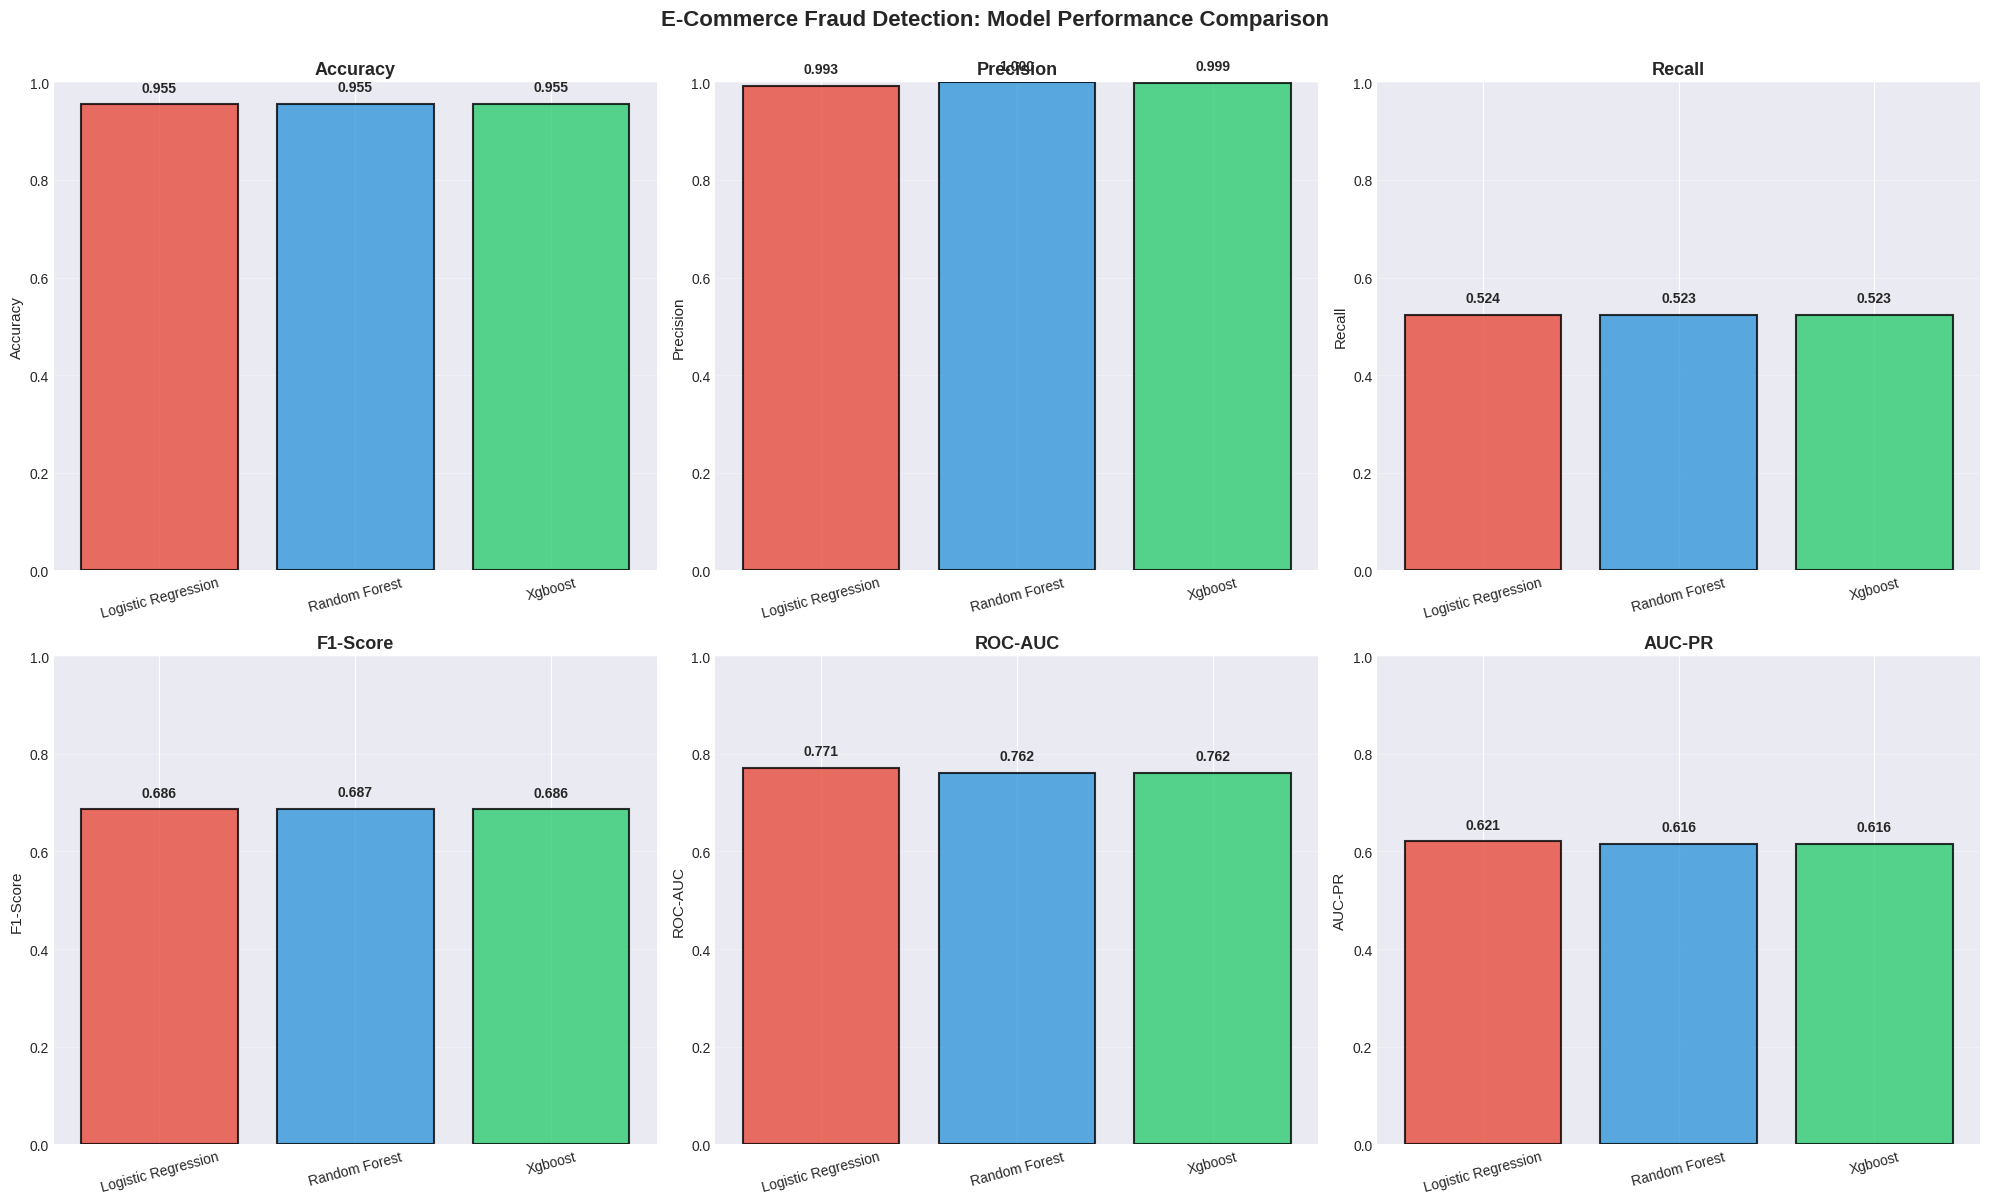

In [70]:
# Performance bar charts
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'AUC-PR']
colors = ['#e74c3c', '#3498db', '#2ecc71']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    values = comparison[metric].values
    bars = ax.bar(comparison['Model'], values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_title(f'{metric}', fontsize=13, fontweight='bold')
    ax.set_ylabel(metric, fontsize=11)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=15)
   
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle('E-Commerce Fraud Detection: Model Performance Comparison', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Confusion Matrices

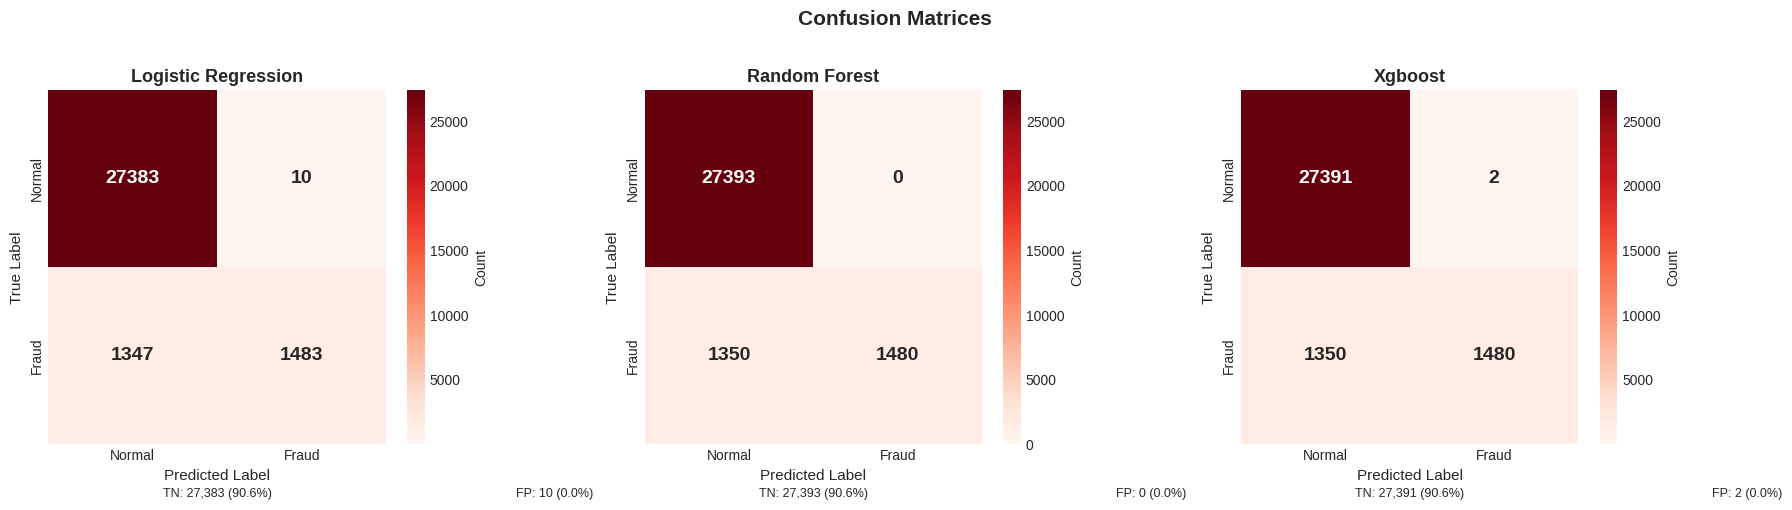

In [71]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, trainer) in enumerate(models.items()):
    y_pred = trainer.predict(X_test_processed)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[idx], 
                xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'],
                cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'})
    
    axes[idx].set_title(f'{model_name.replace("_", " ").title()}', fontsize=13, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)
    
    # Add percentages
    tn, fp, fn, tp = cm.ravel()
    total = cm.sum()
    axes[idx].text(0.5, -0.15, f'TN: {tn:,} ({tn/total*100:.1f}%)', 
                   ha='center', transform=axes[idx].transAxes, fontsize=9)
    axes[idx].text(1.5, -0.15, f'FP: {fp:,} ({fp/total*100:.1f}%)', 
                   ha='center', transform=axes[idx].transAxes, fontsize=9)

plt.suptitle('Confusion Matrices', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### ROC Curves

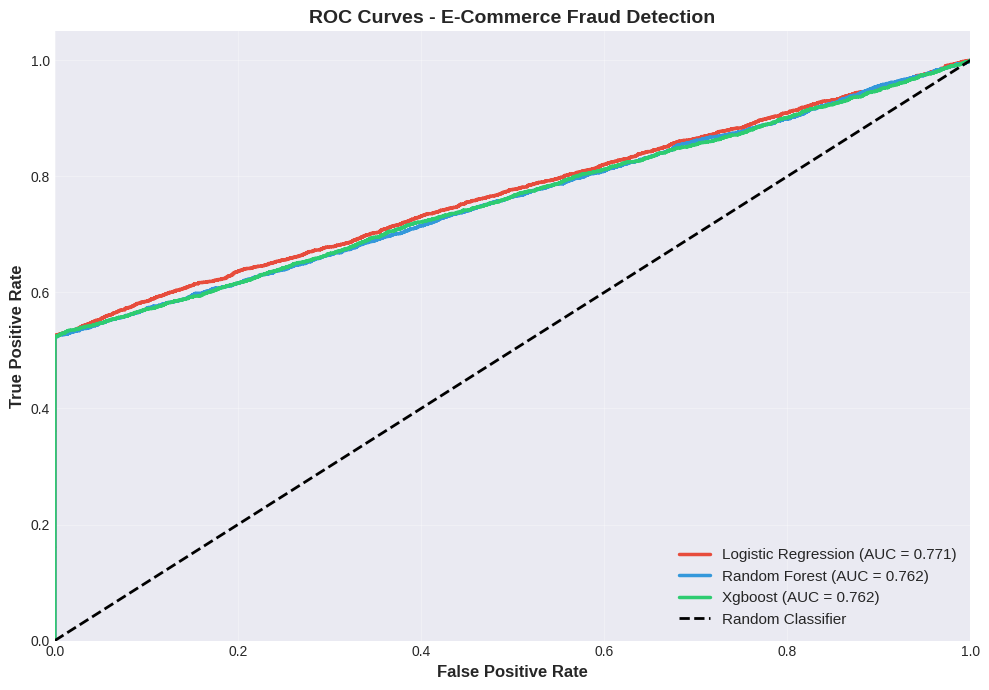

In [72]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))
colors = ['#e74c3c', '#3498db', '#2ecc71']

for idx, (model_name, trainer) in enumerate(models.items()):
    y_pred_proba = trainer.predict_proba(X_test_processed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[idx], lw=2.5, 
            label=f'{model_name.replace("_", " ").title()} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - E-Commerce Fraud Detection', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Precision-Recall Curves (Most Important for Imbalanced Data)

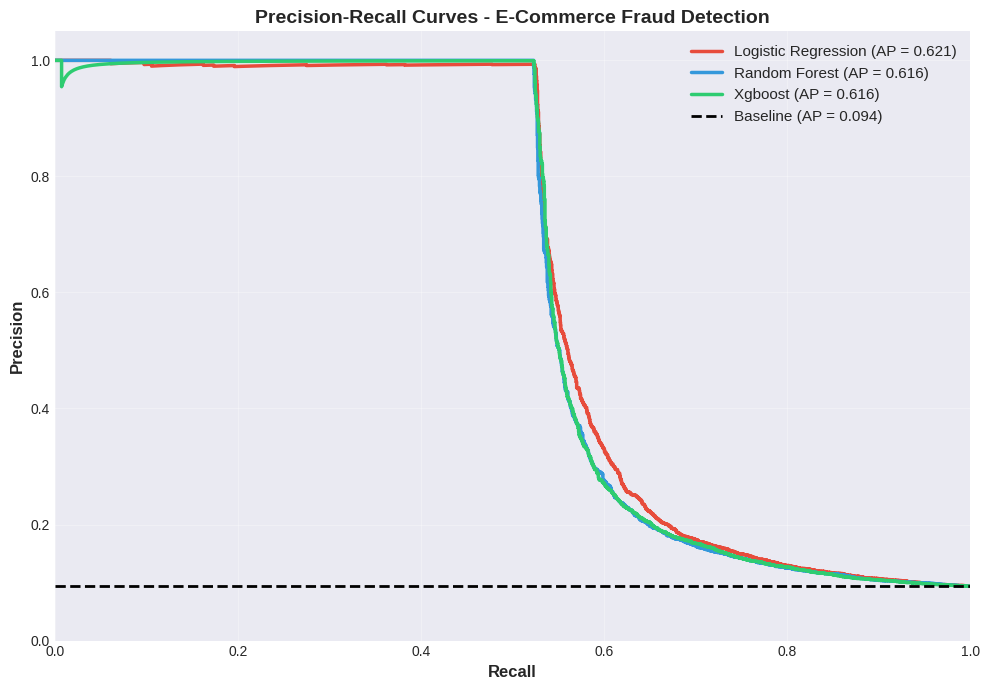


⭐ AUC-PR (Precision-Recall) is more informative than ROC-AUC for imbalanced data
   → It focuses on the positive (fraud) class performance
   → Higher AUC-PR = Better fraud detection capability


In [73]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 7))
colors = ['#e74c3c', '#3498db', '#2ecc71']

for idx, (model_name, trainer) in enumerate(models.items()):
    y_pred_proba = trainer.predict_proba(X_test_processed)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    plt.plot(recall, precision, color=colors[idx], lw=2.5, 
            label=f'{model_name.replace("_", " ").title()} (AP = {avg_precision:.3f})')

# Baseline
baseline = y_test.sum() / len(y_test)
plt.axhline(y=baseline, color='k', linestyle='--', lw=2, label=f'Baseline (AP = {baseline:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curves - E-Commerce Fraud Detection', fontsize=14, fontweight='bold')
plt.legend(loc="best", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("⭐ AUC-PR (Precision-Recall) is more informative than ROC-AUC for imbalanced data")
print("   → It focuses on the positive (fraud) class performance")
print("   → Higher AUC-PR = Better fraud detection capability")
print("="*80)

## 7. Feature Importance & Explainability


FEATURE IMPORTANCE ANALYSIS

Random Forest - Top 15 Most Important Features

                Feature  Importance
         quick_purchase    0.274464
                  month    0.272619
time_since_signup_hours    0.231266
           day_of_month    0.070216
            day_of_week    0.065995
              age_group    0.029808
            hour_of_day    0.019815
                    age    0.017438
     log_purchase_value    0.005070
         purchase_value    0.005019
                  sex_M    0.002357
             source_SEO    0.001880
          source_Direct    0.001250
   is_high_risk_country    0.001034
             browser_IE    0.000472


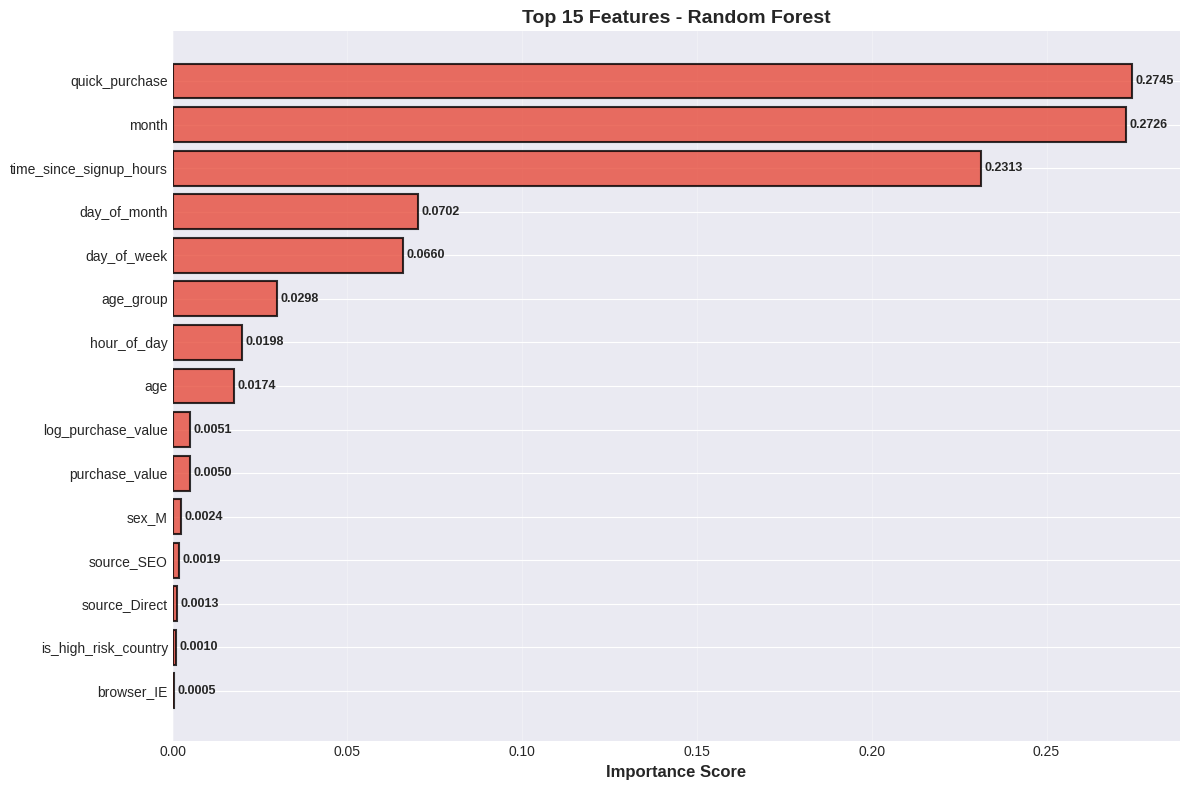


✓ FEATURE IMPORTANCE ANALYSIS COMPLETE


In [ ]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get best model
best_model_key = best_model.lower().replace(' ', '_')
best_trainer = models[best_model_key]

if hasattr(best_trainer.model, 'feature_importances_'):
    print(f"\n{'='*80}")
    print(f"{best_model} - Top 15 Most Important Features")
    print(f"{'='*80}")
    
    importance = best_trainer.model.feature_importances_
    feature_names = X_train_processed.columns if hasattr(X_train_processed, 'columns') else [f'Feature_{i}' for i in range(len(importance))]
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False).head(15)
    
    print("\n" + feature_importance_df.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'], 
             color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'], fontsize=10)
    plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
    plt.title(f'Top 15 Features - {best_model}', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(feature_importance_df['Importance']):
        plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("✓ FEATURE IMPORTANCE ANALYSIS COMPLETE")
print("="*80)

### SHAP Analysis

In [ ]:
print("\n" + "="*80)
print("SHAP EXPLAINABILITY")
print("="*80)
print("\nFor comprehensive SHAP analysis, see: notebooks/shap_explanability.ipynb")
print("\nSHAP Analysis includes:")
print("  1. Summary Plot (Global Feature Importance)")
print("  2. Force Plots (Individual Predictions)")
print("  3. Dependence Plots (Feature Interactions)")
print("  4. Waterfall Charts (Decision Breakdown)")
print("\n" + "="*80)

# Quick SHAP sample (optional)
try:
    import shap
    
    print("\nQuick SHAP Summary:")
    print("-"*80)
    
    explainer = shap.TreeExplainer(best_trainer.model)
    sample_size = min(100, len(X_test_processed))
    shap_values = explainer.shap_values(X_test_processed[:sample_size])
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_processed[:sample_size], 
                      plot_type="bar", show=False, max_display=15)
    plt.title(f'SHAP Feature Importance - {best_model}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✓ SHAP summary generated")
    
except ImportError:
    print("\nSHAP not installed")
except Exception as e:
    print(f"\nSHAP analysis skipped: {str(e)}")


SHAP EXPLAINABILITY

For comprehensive SHAP analysis, see: notebooks/shap_explanability.ipynb

SHAP Analysis includes:
  1. Summary Plot (Global Feature Importance)
  2. Force Plots (Individual Predictions)
  3. Dependence Plots (Feature Interactions)
  4. Waterfall Charts (Decision Breakdown)


SHAP analysis skipped: initialization of _internal failed without raising an exception


## 8. Model Persistence & Recommendations

In [ ]:
import joblib
from pathlib import Path
from src.config import MODELS_DIR

print("\n" + "="*80)
print("SAVING MODEL TO DISK")
print("="*80)

models_dir = Path(MODELS_DIR)
models_dir.mkdir(parents=True, exist_ok=True)

# Save best model
model_path = models_dir / f"ecommerce_{best_model_key}_model.joblib"
best_trainer.save_model(str(model_path))
print(f"\n✓ Model Saved:")
print(f"  Path: {model_path}")
print(f"  Model: {best_model}")
print(f"  F1-Score: {best_f1:.4f}")
print(f"  Recall: {best_recall:.4f}")
print(f"  AUC-PR: {best_auc_pr:.4f}")

# Save preprocessor
preprocessor_path = models_dir / "ecommerce_preprocessor.joblib"
joblib.dump(preprocessor, preprocessor_path)
print(f"\n✓ Preprocessor Saved:")
print(f"  Path: {preprocessor_path}")

# Save feature engineer
feature_engineer_path = models_dir / "ecommerce_feature_engineer.joblib"
joblib.dump(feature_engineer, feature_engineer_path)
print(f"\n✓ Feature Engineer Saved:")
print(f"  Path: {feature_engineer_path}")

print("\n" + "="*80)
print("✓ ALL ARTIFACTS SAVED")
print("="*80)


SAVING MODEL TO DISK
2026-01-31 22:07:53,251 - src.model_trainer - INFO - Saving model to /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions/models/ecommerce_random_forest_model.joblib
2026-01-31 22:07:53,309 - src.model_trainer - INFO - Model saved successfully

✓ Model Saved:
  Path: /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions/models/ecommerce_random_forest_model.joblib
  Model: Random Forest
  F1-Score: 0.6868
  Recall: 0.5230
  AUC-PR: 0.6157

✓ Preprocessor Saved:
  Path: /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions/models/ecommerce_preprocessor.joblib

✓ Feature Engineer Saved:
  Path: /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions/models/ecommerce_feature_engineer.joblib

✓ ALL ARTIFACTS SAVED
2026-01-31 22:07:53,309 - src.model_trainer - INFO - Model saved successfull

## 9. Prediction
Run a quick prediction on a few sample rows using the saved artifacts.

In [ ]:
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
from src.config import MODELS_DIR
print("\n" + "="*80)
print("PREDICTION: SAMPLE E-COMMERCE TRANSACTIONS")
print("="*80)

models_dir = Path(MODELS_DIR)
threshold = 0.5

# Resolve model path
model_path = None
if 'best_model_key' in globals():
    candidate = models_dir / f"ecommerce_{best_model_key}_model.joblib"
    if candidate.exists():
        model_path = candidate
if model_path is None:
    candidates = list(models_dir.glob("ecommerce_*_model.joblib"))
    if candidates:
        model_path = candidates[0]

if model_path is None:
    raise FileNotFoundError("No ecommerce model file found. Run training and persistence first.")

model_data = joblib.load(model_path)
model = model_data['model']
model_features = model_data.get('feature_names')

# Load preprocessor/feature engineer from disk if available
preprocessor_path = models_dir / "ecommerce_preprocessor.joblib"
feature_engineer_path = models_dir / "ecommerce_feature_engineer.joblib"
if preprocessor_path.exists():
    preprocessor = joblib.load(preprocessor_path)
if feature_engineer_path.exists():
    feature_engineer = joblib.load(feature_engineer_path)

# Prepare input data
if 'fraud_data' not in globals():
    raise RuntimeError("fraud_data not found. Run the data loading cell first.")

sample_df = fraud_data.sample(n=min(10, len(fraud_data)), random_state=42).copy()
engineered = feature_engineer.engineer_features(sample_df, fit=False)

columns_to_drop = ['class', 'signup_time', 'purchase_time', 'device_id',
                   'user_id', 'ip_address', 'browser_source', 'ip_country']
existing_cols_to_drop = [c for c in columns_to_drop if c in engineered.columns]
X = engineered.drop(columns=existing_cols_to_drop, errors='ignore')
X = X.select_dtypes(include=['number', 'bool'])

if model_features is not None:
    missing_cols = set(model_features) - set(X.columns)
    for col in missing_cols:
        X[col] = 0
    X = X[model_features]

# Transform and predict
X_proc = preprocessor.transform(X)
proba = model.predict_proba(X_proc)
if proba.ndim > 1:
    proba = proba[:, 1]
preds = (proba >= threshold).astype(int)

results_df = sample_df.reset_index(drop=True).copy()
results_df['fraud_probability'] = proba
results_df['prediction'] = preds
results_df['threshold'] = threshold

print(results_df[['fraud_probability', 'prediction', 'threshold']].head(10).to_string(index=False))
print("\n✓ Prediction complete")


PREDICTION: SAMPLE E-COMMERCE TRANSACTIONS
2026-01-31 22:07:53,378 - src.feature_engineer - INFO - Engineering features for fraud data
2026-01-31 22:07:53,384 - src.feature_engineer - INFO - Created temporal features
2026-01-31 22:07:53,387 - src.feature_engineer - INFO - Created time difference features
2026-01-31 22:07:53,384 - src.feature_engineer - INFO - Created temporal features
2026-01-31 22:07:53,387 - src.feature_engineer - INFO - Created time difference features
2026-01-31 22:07:53,388 - src.feature_engineer - INFO - Converted IP addresses to integers
2026-01-31 22:07:53,391 - src.feature_engineer - INFO - Created purchase value features
2026-01-31 22:07:53,394 - src.feature_engineer - INFO - Created age group features
2026-01-31 22:07:53,396 - src.feature_engineer - INFO - Created interaction features
2026-01-31 22:07:53,401 - src.feature_engineer - INFO - One-hot encoded: ['browser', 'source', 'sex']
2026-01-31 22:07:53,388 - src.feature_engineer - INFO - Converted IP addr